## Implementing Yann LeCun's LeNet-5 in PyTorch

<img src="image\image-18.png" alt="예시 이미지" width="600">

<img src="image\1ueA-rooOaiIo3s2rVVz3Ww.webp" alt="예시 이미지" width="800">

In [1]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [2]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 16
N_EPOCHS = 10

IMG_SIZE = 32
N_CLASSES = 10

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [16]:
# transforms 정의하기
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# data set 다운받고 생성하기
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transform,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transform)

# data loader 정의하기
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

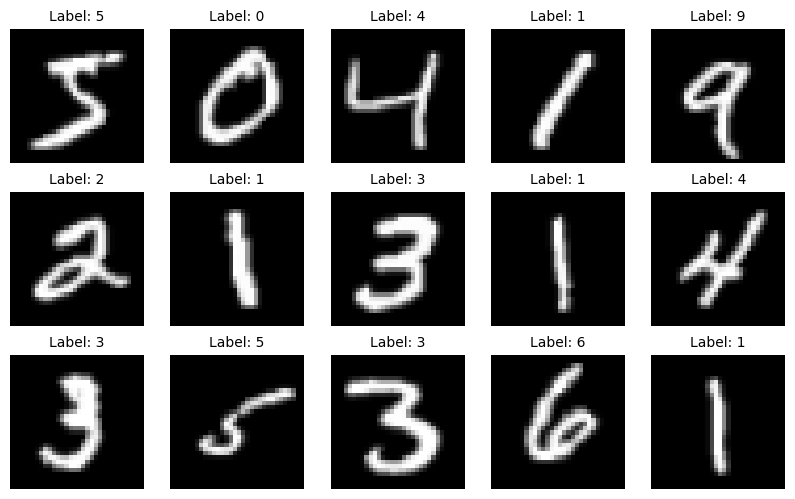

In [47]:
num_images = 15
n_cols = 5
n_rows = (num_images + n_cols - 1) // n_cols  # ceil 방식

# 그림 틀 만들기
fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))

for i in range(num_images):
    image, label = train_dataset[i]          # transform 적용된 이미지 (Tensor)
    image_np = image.detach().cpu().squeeze().numpy()  # (1,32,32) → (32,32)

    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Label: {label}", fontsize=10)
    plt.axis('off')

In [17]:
def get_accuracy(model, data_loader, device):
    '''
    전체 data_loader에 대한 예측의 정확도를 계산하는 함수
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [18]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    training loop의 training 단계에 대한 함수
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # 순전파
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # 역전파
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [19]:
def validate(valid_loader, model, criterion, device):
    '''
    training loop의 validation 단계에 대한 함수
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # 순전파와 손실 기록하기
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [20]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    전체 training loop를 정의하는 함수
    '''
    from datetime import datetime

    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        # 매 epoch마다 accuracy 저장
        train_acc = get_accuracy(model, train_loader, device=device)
        valid_acc = get_accuracy(model, valid_loader, device=device)
        train_accuracies.append(float(train_acc))  # train_accuracies.append(train_acc.item())/ valid_accuracies.append(valid_acc.item())
        valid_accuracies.append(float(valid_acc))

        if epoch % print_every == (print_every - 1):
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    plot_accuracies(train_accuracies, valid_accuracies)

    return model, optimizer, (train_losses, valid_losses, train_accuracies, valid_accuracies)


In [21]:
def plot_losses(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, label='Training Loss', color='red')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracies(train_accs, valid_accs):
    epochs = range(1, len(train_accs) + 1)
    plt.figure()
    plt.plot(epochs, train_accs, label='Training Loss', color='red')
    plt.plot(epochs, valid_accs, label='Validation Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.show()


#### 출력 차원 계산

**W_out = (W_in - K + 2P) // S + 1**

* W_in: 입력 너비/높이

* K: 커널 크기 (kernel_size)

* P: 패딩 (기본은 0)

* S: 스트라이드 (stride)

AvgPool2D도 같은 공식 적용

### 각 레이어별 계산
<pre>
초기 입력: (32, 32)

1. conv2d(1, 6, kernel_size=5, stride=1)
padding=0, stride=1

크기: (32 - 5 + 0) // 1 + 1 = 28
(28, 28)

Tanh()
크기 변화 없음
(28, 28)

3. AvgPool2d(kernel_size=2)
stride는 기본값으로 kernel_size와 같음 → stride=2

크기: (28 - 2) // 2 + 1 = 14
(14, 14)

4. Conv2d(6, 16, kernel_size=5, stride=1)
크기: (14 - 5) // 1 + 1 = 10
(10, 10)

5. Tanh()
(10, 10)

6. AvgPool2d(kernel_size=2)
stride=2

크기: (10 - 2) // 2 + 1 = 5
(5, 5)

7. Conv2d(16, 120, kernel_size=5, stride=1)
크기: (5 - 5) // 1 + 1 = 1
(1, 1)

8. Tanh()
(1, 1)

최종 출력 크기:
채널 수: 120

공간 크기: (1, 1)

결과: (batch_size, 120, 1, 1)
이후 torch.flatten(x, 1)을 적용하면 → (batch_size, 120)이 됩니다.
</pre>

In [22]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        # Default of stride, padding 
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
     
        self.feature_extractor = nn.Sequential(            # input dim : (32, 32)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        # print(x.shape)               # [16, 120, 1, 1]
        x = torch.flatten(x, 1)      # [16, 120]
        # print(x.shape)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [23]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Epoch: 0	Train loss: 0.1981	Valid loss: 0.0955	Train accuracy: 97.17	Valid accuracy: 97.01
Epoch: 1	Train loss: 0.0741	Valid loss: 0.0680	Train accuracy: 98.12	Valid accuracy: 97.94
Epoch: 2	Train loss: 0.0557	Valid loss: 0.0543	Train accuracy: 98.75	Valid accuracy: 98.43
Epoch: 3	Train loss: 0.0452	Valid loss: 0.0574	Train accuracy: 98.84	Valid accuracy: 98.26
Epoch: 4	Train loss: 0.0372	Valid loss: 0.0461	Train accuracy: 99.05	Valid accuracy: 98.44
Epoch: 5	Train loss: 0.0328	Valid loss: 0.0463	Train accuracy: 99.21	Valid accuracy: 98.64
Epoch: 6	Train loss: 0.0283	Valid loss: 0.0455	Train accuracy: 99.40	Valid accuracy: 98.65
Epoch: 7	Train loss: 0.0245	Valid loss: 0.0495	Train accuracy: 99.24	Valid accuracy: 98.46
Epoch: 8	Train loss: 0.0224	Valid loss: 0.0506	Train accuracy: 99.31	Valid accuracy: 98.61
Epoch: 9	Train loss: 0.0207	Valid loss: 0.0393	Train accuracy: 99.56	Valid accuracy: 98.86


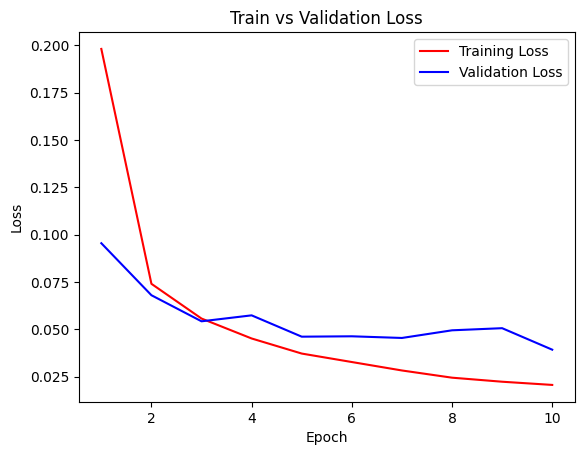

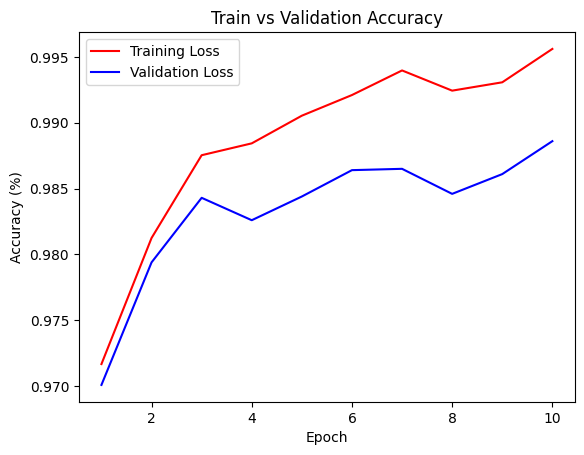

In [24]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

## 학습 모델 저장

In [29]:
# 모델 저장 (학습 후)
torch.save(model.state_dict(), './model/trained_model.pth')

In [30]:
# 3. 불러오기
loaded_model = LeNet5(N_CLASSES)
loaded_model.load_state_dict(torch.load('./model/trained_model.pth'))
loaded_model.to(DEVICE)
# model.eval()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

## 예측하기

In [31]:
def predict_and_plot(model, dataset, index, device, class_names=None):
    '''
    dataset: torch.utils.data.Dataset (ex: train_dataset or valid_dataset)
    index: 예측할 이미지 인덱스
    class_names: (선택) 클래스 이름 리스트. 없으면 숫자로 출력
    '''

    model.eval()

    # 데이터 준비
    image, true_label = dataset[index]
    input_tensor = image.unsqueeze(0).to(device)  # (1, C, H, W)

    # 모델 예측
    with torch.no_grad():
        logits, probs = model(input_tensor)
        predicted_class = torch.argmax(probs, dim=1).item()
        predicted_prob = probs[0, predicted_class].item()

    # numpy 변환 (1채널이면 squeeze)
    image_np = image.squeeze().cpu().numpy()

    # 클래스 이름이 있다면 변환
    true_label_str = class_names[true_label] if class_names else str(true_label)
    predicted_label_str = class_names[predicted_class] if class_names else str(predicted_class)

    # 시각화
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Ground True: {true_label_str}\nPred: {predicted_label_str} ({predicted_prob:.2%})")
    plt.axis('off')
    plt.show()


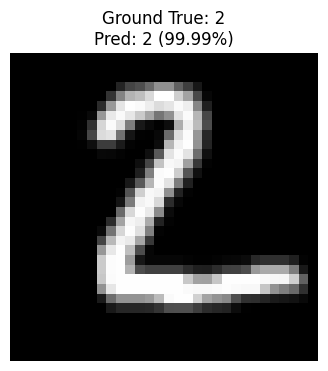

In [32]:
predict_and_plot(loaded_model, valid_dataset, index=1, device=DEVICE)

In [33]:
def predict_and_plot_multiple(model, dataset, indices, device, class_names=None):
    '''
    여러 샘플을 예측하고 시각화

    model: 학습된 모델
    dataset: torch.utils.data.Dataset (ex: valid_dataset)
    indices: 예측할 샘플 인덱스 리스트
    device: torch device
    class_names: 클래스 이름 리스트 (없으면 숫자로 처리)
    '''

    model.eval()
    n = len(indices)
    n_cols = 5
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))

    for i, idx in enumerate(indices):
        image, true_label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        # 예측
        with torch.no_grad():
            logits, probs = model(input_tensor)
            predicted_class = torch.argmax(probs, dim=1).item()
            predicted_prob = probs[0, predicted_class].item()

        # 레이블 이름 처리
        true_str = class_names[true_label] if class_names else str(true_label)
        pred_str = class_names[predicted_class] if class_names else str(predicted_class)

        # 이미지 준비
        image_np = image.squeeze().cpu().numpy()

        # 시각화
        ax = axes[i // n_cols, i % n_cols] if n > 1 else axes
        ax.imshow(image_np, cmap='gray')
        ax.set_title(f"Ground True: {true_str}\nPred: {pred_str} ({predicted_prob:.1%})", fontsize=10)
        ax.axis('off')

    # 남은 subplot 빈칸 제거
    for j in range(n, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    plt.tight_layout()
    plt.show()

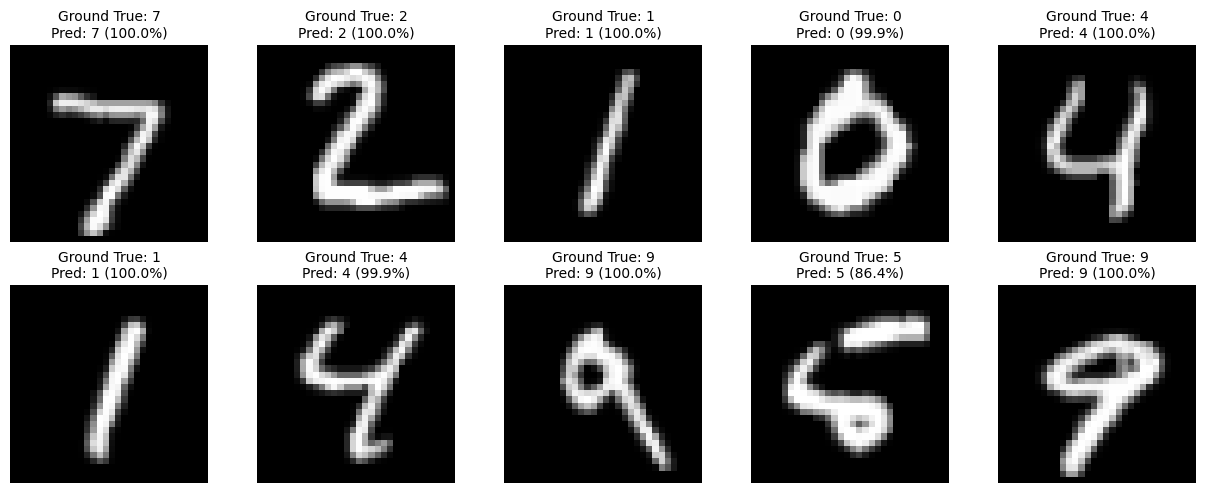

In [34]:
# 예시: 10개의 인덱스 샘플 선택
sample_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# 클래스 이름이 있다면
class_names = [str(i) for i in range(10)]

# 함수 호출
predict_and_plot_multiple(loaded_model, valid_dataset, sample_indices, device=DEVICE, class_names=class_names)


## Plolt Confusion Matrix

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, device, class_names=None):
    '''
    Confusion matrix를 계산하고 시각화하는 함수

    model: 학습된 모델
    data_loader: validation 또는 test DataLoader
    device: torch 디바이스
    class_names: 클래스 이름 리스트 (없으면 숫자로 출력)
    '''

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            logits, _ = model(X)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Confusion matrix 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 클래스 이름 설정
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]

    # 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


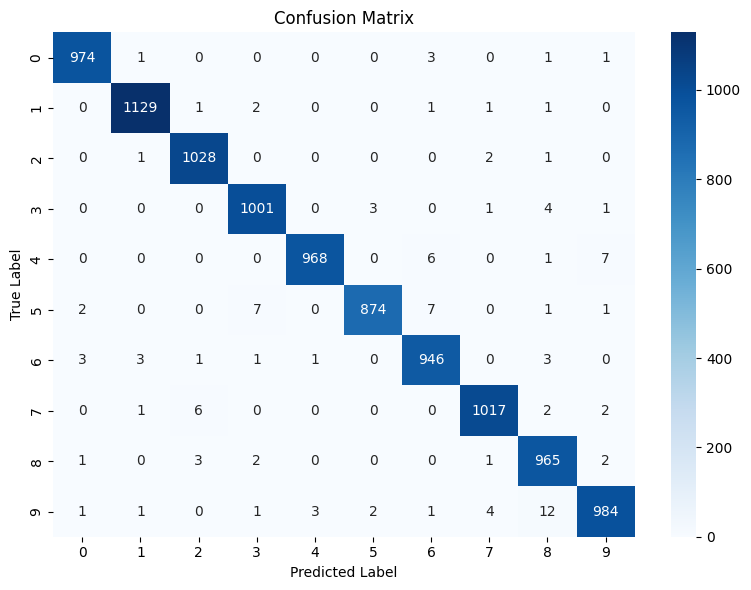

In [36]:
# 클래스 이름 (예: 숫자 0~9)
class_names = [str(i) for i in range(10)]

# 혼동 행렬 출력
plot_confusion_matrix(loaded_model, valid_loader, device=DEVICE, class_names=class_names)